# Washoe Tourism Impact

---
## Sources and Links

Dataset : [NevadaTomrrow.org](https://www.nevadatomorrow.org/indicators/index/view?indicatorId=14201&localeId=1813)

IBM CRISP-DM image and explination : [IBM.com](https://www.ibm.com/docs/en/spss-modeler/saas?topic=dm-crisp-help-overview)

---
## Overview

- title
- sources and links
- overview
- imports
- business understanding
- methodoligy
- functions
- exploritory data analysis
- trends and growth
- spending per category
- conclusion

---
## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [2]:
now = datetime.now()
print(f'This notebook was last updated at : {now} PT')

This notebook was last updated at : 2025-07-02 12:58:48.066578 PT


In [3]:
df = pd.read_csv('indicator_data_download_20250626.csv')

---
## Business Understanding
This repository and notebook intend to dive into the economics of the Washoe Valley area within Northern Nevada using data collected on tourism and the income it generates. This will primarily be done through breaking down how tourists spend their money by category, which include : `Food and Beverage`, `Gaming`, `Lodging`, `Recreation` and `Retail`. This information allows local businesses to target a specific demographic of tourists they belive they can best serve, therefore bringing more money and people into the economy of northern Nevada.

---
## Methodoligy
A common methodology used when attempting to create a model is CRISP-DM, which stands for:
- `CR`oss
- `I`dustry
- `S`tandard
- `p`rocess
- (for)
- `D`ata
- `M`ining

A good visual for how this works is a model designed by IBM

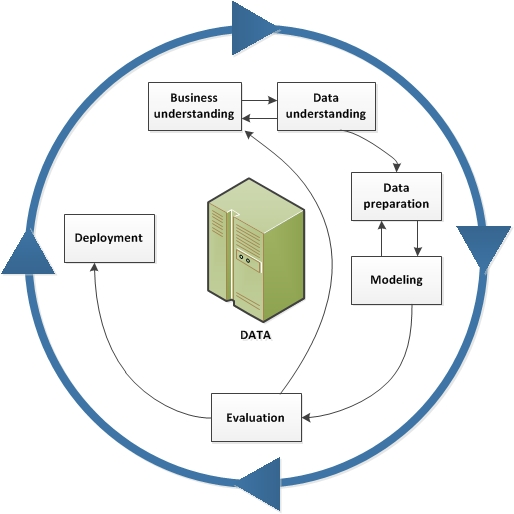

This methodology is an overarching workflow style, where upon completing a step in the cycle, the next step is started and so on. Where this model really helps though is that it's non linear, meaning if needed, returning to a previous step can assist with assuring a thorough and complete modeling process.



---
## Functions

In [31]:
def totals_by_year(df, col, val):

    '''
    ---
    this function returns the total spending per yer for the given column and category.
    ---
    requirments : what df(str) to act upon, what col(str) to act upon and what val(str) column to gather the values from.
    ---
    example : totals_by_year(df, 'Period of Measure', 'Indicator Rate Value') output : 
    	
        year    value
    9	2014    2428.4
    8	2015    2547.6
    7	2016    2662.2
    6	2017    2747.6
    5	2018    2831.4
    4	2019    2925.5
    3	2020    1919.1
    2	2021    17032.8
    1	2022    18787.2
    0	2023    19950.6
    --- 
    this function also plots the results.
    ---
    '''
    
    
    totals_by_year = {}

    for ind, row in df.iterrows():
        year = row[col]
        value = row[val]

        if year in totals_by_year:
            totals_by_year[year] += value
        else:
            totals_by_year[year] = value

    yearly_totals = pd.DataFrame(list(totals_by_year.items()), columns = ['year', 'value'])
    yearly_totals_ = yearly_totals.sort_values(by = 'year', ascending = True)
    
    fig, ax = plt.subplots()
    
    yearly_totals_.plot(x = 'year', y = 'value', kind = 'bar', ax = ax)

    ax.get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, p: format(int(x), ','))) # format labels

    ax.set_title(f'{val} Per Year')
    ax.set_ylabel('Value')
    
    return yearly_totals_

In [5]:
def get_year_avg(start, end, col, val, df):
    
    '''
    ---
    this function averages the values between the given years.
    ---
    requirements : start year(int), end year(int), col(str) this must be `Period of Measure` and val(str) the column of which 
    the values are derived from and the df(str) to be used.
    ---
    example : get_year_avg(2010, 2014, 'Period of Measure', 'Indicator Rate Value', df) output :
    '2,333'
    ---
    '''
    
    mask = (df[col] >= start) & (df[col] <= end)
    filter = df.loc[mask, val]

    return round(filter.mean(), 2)   

In [6]:
def get_yoy(start, end, col, val, df):
    
    '''
    ---
    this function calculates the year-over-year value with the given years and columns. the equation is : 
    ((Current Value - Previous Value) / Previous Value) * 100.
    ---
    requirements : start year(int), end year(int), col(str) this must be `Period of Measure`, and val(str) the column of which 
    the values are derived from and the df(str) to be used.
    ---
    example : get_yoy(2014, 2019, 'Period of Measure', 'Indicator Rate Value', df) output :
    'Between the years of 2014 and 2019, the Year Over Year value is 0.038 or 3.8%'
    ---
    '''
    
    mask = (df[col] >= start) & (df[col] <= end)
    filter = df.loc[mask].copy()

    filter.sort_values(col, inplace = True)
    filter.reset_index(drop = True, inplace = True)

    g_rate = []
    for i in range(1, len(filter)):
        prev_val = filter.loc[i - 1, val]
        curr_val = filter.loc[i, val]
        curr_year = filter.loc[i, col]

        if curr_year < start:
            continue

        if prev_val == 0:
            continue

        g = (curr_val - prev_val) / prev_val
        g_rate.append(g)
    if not g_rate:
        return None
    yoy = round(sum(g_rate) / len(g_rate), 3)
    yoy_p = round(yoy * 100, 2)

    return f'Between the years of {start} and {end}, the Year Over Year value is {yoy} or {yoy_p}%'

In [33]:
def top_cat_per_year(df):

    '''
    ---
    this funnction returns the top category per year.
    ---
    requirements : df(str).
    ---
    example : top_cat_per_year(df) output : 
    
        Year    Top Category    Top Value
    2	2021       Gaming         698.3
    1	2023       Gaming         717.1
    0	2022       Gaming         719.1
    ---
    this function also plots the results.
    ---
    '''
    
    
    df['Breakout Rate Value'] = pd.to_numeric(df['Breakout Rate Value'], errors = 'coerce')
    df_ = df.dropna(subset = ['Period of Measure', 'Breakout Subcategory', 'Breakout Rate Value'])
    
    highest_per_year = {}

    for year in df_['Period of Measure'].unique():
        year_df = df_[df_['Period of Measure'] == year]

        cat_totals = year_df.groupby('Breakout Subcategory')['Breakout Rate Value'].sum()

        top_cat = cat_totals.idxmax()
        top_val = cat_totals.max()

        highest_per_year[year] = (top_cat, top_val)

    data = [
    {"Year": year, "Top Category": category, "Top Value": value}
    for year, (category, value) in highest_per_year.items()]
    df_top = pd.DataFrame(data)
    df_top = df_top.sort_values("Top Value", ascending = False).reset_index(drop=True)

    fig, ax = plt.subplots()
    df_top.plot(x = 'Year', y = 'Top Value', kind = 'barh', ax=ax)

    ax.set_title('Top Category Each Year')
    ax.set_xlabel('Total Spending (in millions)')
    
    return df_top.sort_values('Top Value', ascending = True)

In [34]:
def subcat_counter(year, df):

    '''
    ---
    this function returns the total spending per category in the given year.
    ---
    requirments : year(int) and df(str).
    ---
    example : subcat_counter(2022, df) output : 

    	sub-category    values
    5	Transport       349.9
    3	Recreation      429.3
    0	Food & beverage 521.9
    2	Lodging         526.0
    4	Retail          585.0
    1	Gaming          719.1
    ---
    this function also plots the results.
    ---
    '''
    
    
    df_y = df[df['Period of Measure'] == year]

    count = {}
    
    for ind, row in df_y.iterrows():
        sub = row['Breakout Subcategory']
        val = row['Breakout Rate Value']
        
        if sub in count:
            count[sub] += val
        else:
            count[sub] = val

    sub_totals = pd.DataFrame(list(count.items()), columns = ['sub-category', 'values'])
    sub_totals = sub_totals.sort_values(by = 'values', ascending = False)
    fig, ax = plt.subplots()

    sub_totals.plot(x = 'sub-category', y = 'values', kind = 'barh', ax=ax)

    ax.set_title(f'Category Spending for the year of {year}')
    ax.set_xlabel('Total Spent (in millions)')

    return sub_totals.sort_values(by = 'values', ascending = True)

---
## Exploritory Data Alalysis (EDA)

In [9]:
df.head()

,Indicator Name,What Is This Indicator,Location Type,Location,Indicator Rate Value,Indicator Rate Value Units,Rate Lower Confidence Interval,Rate Upper Confidence Interval,Indicator Count Value,Indicator Count Value Units,...,Breakout Rate Value,Breakout Rate Value Units,Breakout Rate Lower Confidence Interval,Breakout Rate Upper Confidence Interval,Breakout Count Value,Breakout Count Value Units,Breakout Count Lower Confidence Interval,Breakout Count Upper Confidence Interval,Breakout Unstable,Breakout Footer
0,Tourism Economic Impact,The economic impact of visitor spending activi...,County,Washoe,3325.1,Million Dollars,NaN,NaN,NaN,NaN,...,556.7,Million Dollars,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN
1,Tourism Economic Impact,The economic impact of visitor spending activi...,County,Washoe,3325.1,Million Dollars,NaN,NaN,NaN,NaN,...,717.1,Million Dollars,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN
2,Tourism Economic Impact,The economic impact of visitor spending activi...,County,Washoe,3325.1,Million Dollars,NaN,NaN,NaN,NaN,...,550.0,Million Dollars,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN
3,Tourism Economic Impact,The economic impact of visitor spending activi...,County,Washoe,3325.1,Million Dollars,NaN,NaN,NaN,NaN,...,497.5,Million Dollars,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN
4,Tourism Economic Impact,The economic impact of visitor spending activi...,County,Washoe,3325.1,Million Dollars,NaN,NaN,NaN,NaN,...,616.2,Million Dollars,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 29 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Indicator Name                            25 non-null     object 
 1   What Is This Indicator                    25 non-null     object 
 2   Location Type                             25 non-null     object 
 3   Location                                  25 non-null     object 
 4   Indicator Rate Value                      25 non-null     float64
 5   Indicator Rate Value Units                25 non-null     object 
 6   Rate Lower Confidence Interval            0 non-null      float64
 7   Rate Upper Confidence Interval            0 non-null      float64
 8   Indicator Count Value                     0 non-null      float64
 9   Indicator Count Value Units               0 non-null      float64
 10  Count Lower Confidence Interval         

In [11]:
df['Location'].value_counts()

Location
Washoe    25
Name: count, dtype: int64

In [12]:
df['What Is This Indicator'].value_counts()

What Is This Indicator
The economic impact of visitor spending activities, including transport, retail, food and beverage, recreation, gaming, and lodging that ultimately increase tax revenues.    25
Name: count, dtype: int64

In [13]:
df['Indicator Rate Value Units'].value_counts()

Indicator Rate Value Units
Million Dollars    25
Name: count, dtype: int64

In [14]:
df['Breakout Subcategory'].head()

0    Food & beverage
1             Gaming
2            Lodging
3         Recreation
4             Retail
Name: Breakout Subcategory, dtype: object

In [15]:
df['Period of Measure'].value_counts()

Period of Measure
2023    6
2022    6
2021    6
2020    1
2019    1
2018    1
2017    1
2016    1
2015    1
2014    1
Name: count, dtype: int64

---
## Trends and Growth

,year,value
9,2014,2428.4
8,2015,2547.6
7,2016,2662.2
6,2017,2747.6
5,2018,2831.4
4,2019,2925.5
3,2020,1919.1
2,2021,17032.8
1,2022,18787.2
0,2023,19950.6


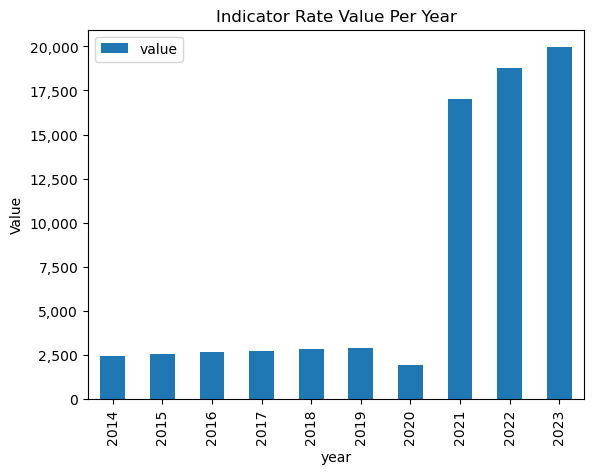

In [16]:
totals_by_year(df, 'Period of Measure', 'Indicator Rate Value')

This plot paints a counterintuitive picture, with spending showing an increase of spending duing the pandemic. While this makes sense for markets such as gaming (non casino gambling) due to people staying home and buying more games to pass the time, this doesn't make sense for tourism, as COVID-19 decimated tourism all throughout the world. This data could include indirect economic impact as well as delayed reporting from casinos and hotels as well as stimulus driven spending. This realization would require further data and research to come to a conclusion. 

In [17]:
get_year_avg(2014, 2019, 'Period of Measure', 'Indicator Rate Value', df)

2690.45

In [18]:
get_year_avg(2019, 2020, 'Period of Measure', 'Indicator Rate Value', df)

2422.3

In [19]:
get_year_avg(2021, 2023, 'Period of Measure', 'Indicator Rate Value', df)

3098.37

Here we can see the average spending across the years, with the average spending from 2014 to 2019 being 2690.45, with a drop in 2019 to 2020, and the major increase duing the pandemic up to 3098.37.

In [20]:
get_yoy(2014, 2019, 'Period of Measure', 'Indicator Rate Value', df)

'Between the years of 2014 and 2019, the Year Over Year value is 0.038 or 3.8%'

In [21]:
get_yoy(2020, 2021, 'Period of Measure', 'Indicator Rate Value', df)

'Between the years of 2020 and 2021, the Year Over Year value is 0.08 or 8.0%'

Year Over Year compares data from one time frame to another, giving insight into performance gains or losses. From 2014 to 2019, there was a YoY increase of 3.8%, with a huge increase of 8% from 2020 to 2021.

---
## Spending per Category

In [22]:
df['Breakout Subcategory'].value_counts()

Breakout Subcategory
Food & beverage    3
Gaming             3
Lodging            3
Recreation         3
Retail             3
Transport          3
Name: count, dtype: int64

,sub-category,values
5,Transport,282.6
3,Recreation,365.4
0,Food & beverage,448.9
2,Lodging,490.9
4,Retail,552.7
1,Gaming,698.3


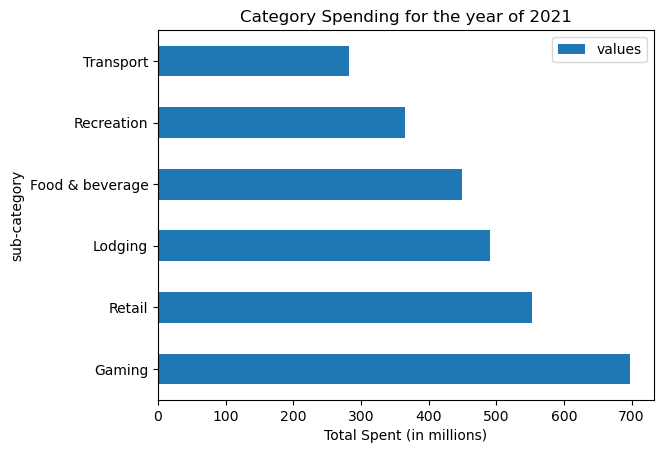

In [23]:
subcat_counter(2021, df)

,sub-category,values
5,Transport,349.9
3,Recreation,429.3
0,Food & beverage,521.9
2,Lodging,526.0
4,Retail,585.0
1,Gaming,719.1


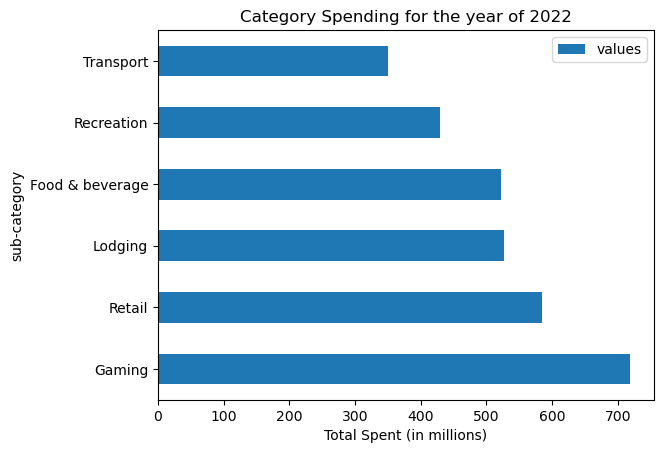

In [24]:
subcat_counter(2022, df)

,sub-category,values
5,Transport,387.6
3,Recreation,497.5
2,Lodging,550.0
0,Food & beverage,556.7
4,Retail,616.2
1,Gaming,717.1


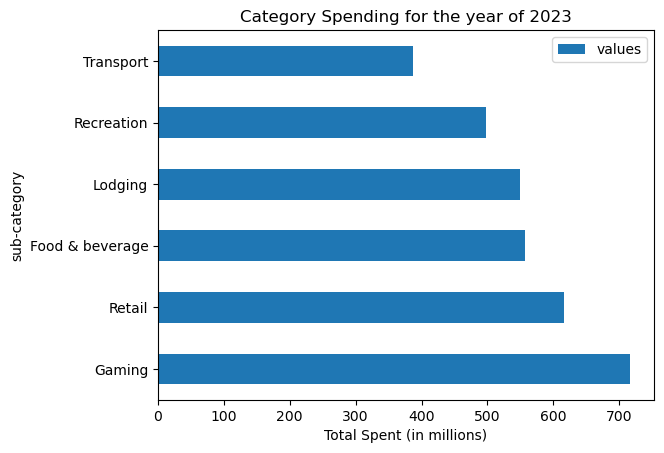

In [25]:
subcat_counter(2023, df)

,Year,Top Category,Top Value
2,2021,Gaming,698.3
1,2023,Gaming,717.1
0,2022,Gaming,719.1


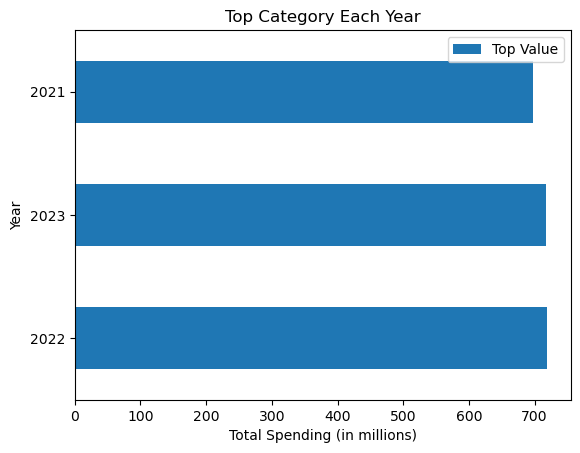

In [26]:
top_cat_per_year(df)

---
# Conclusion

In conclusion, the gamimg market is still the most profitable industry for the Washoe Valley area. There is some nuances regarding the genral income of gambling, but this will have to be explored an a later time.